# **AT&T - DÉTECTION DE SPAMS**
### **BLOC 04 : DEEP LEARNING**

---

### Importation des bibliothèques & Configuration

In [ ]:
# Bibliothèques standards
import os
import re
import string
import collections
from collections import Counter
import numpy as np
import pandas as pd


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-Learn (metrics & split)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# PyTorch Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchinfo import summary
import torch.nn.functional as F

# Outils de traitement du langage naturel (NLP)
import spacy
nlp = spacy.load("en_core_web_sm")
import tiktoken

# Transformateurs (Transformers)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Optimiseurs (Optimizers)
from torch.optim import AdamW

# Configuration Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


---

## **PARTIE 1 | Analyse exploratoire des données (EDA) & Prétraitement (preprocessing)**

### 1. Chargement et exploration initiale

In [ ]:
# Chargement du dataset
df = pd.read_csv(r'spam.csv', encoding='latin-1')

# Aperçu des premières lignes
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Informations générales sur le dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [ ]:
# Suppression des colonnes inutiles
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Renommage des colonnes pour plus de clarté
df.columns = ['label', 'message']

# Vérification des valeurs manquantes
print("Valeurs manquantes :")
print(df.isnull().sum())

Valeurs manquantes :
label      0
message    0
dtype: int64


In [ ]:
# Distribution des classes (Donut chart)

counts = df['label'].value_counts().reset_index()
counts.columns = ['label', 'count']

fig = px.pie(
    counts,
    names='label',
    values='count',
    title='Répartition des messages Ham (non-spam) vs Spam',
    width=600, height=400,
    color='label',
    color_discrete_map={'ham':'#07bf01', 'spam':'#f10600'},
    hole=0.4
)

fig.update_traces(textinfo='percent+label')

fig.show()

In [ ]:
# Distribution de la longueur des messages (Histogramme)

df['length'] = df['message'].apply(len)

fig = px.histogram(df, x="length", color="label",
                   title="Distribution de la longueur des messages (Spam vs Ham)",
                   barmode='overlay',
                   opacity=0.75,
                   color_discrete_map={'ham':'#07bf01', 'spam':'#f10600'})
fig.show()

**Différence structurelle entre les spams et les hams** \
Les **spams** ont tendance à être **plus longs** (calibrés autour de 160 caractères). \
Cette constatation peut nous aider à orienter le choix de features comme la longueur du message ou le nombre de mots dans un modèle de classification.

*En anglais, on compte en moyenne 4,5 à 5 caractères par mot (espaces inclus).* \
*200 caractères ≈ 40 à 45 mots et 300 caractères ≈ 60 à 65 mots (selon la longueur des mots et la ponctuation).*

In [ ]:
# 40 mots les plus fréquents dans les hams et spams avec fonction

def plot_top_words(messages, label, color_scale, n=40):
    words = ' '.join(messages).split()
    word_counts = collections.Counter(words).most_common(n)
    words, counts = zip(*word_counts)

    fig = px.bar(
        x=words,
        y=counts,
        title=f'{n} mots les plus fréquents dans les {label}s',
        labels={'x': 'Mots', 'y': 'Fréquence'},
        color=counts,
        color_continuous_scale=color_scale
    )
    fig.update_layout(xaxis_tickangle=45)
    fig.show()

ham_messages = df[df['label'] == 'ham']['message']
plot_top_words(ham_messages, label='ham', color_scale=['#c0f5c0', '#07bf01'])

spam_messages = df[df['label'] == 'spam']['message']
plot_top_words(spam_messages, label='spam', color_scale=['#f9c0c0', '#f10600'])


#### **Indicateurs lexicaux discriminants**

**Ham : sphère privée et conversationnelle** \
On observe une prédominance des pronoms personnels première et deuxième personne ("I", "you", "i", "I'm", "u", "U", "me", "my", "your") et de termes relationnels. \
Cela traduit des échanges interpersonnels, subjectifs et informatifs,  ce qui peut être capté par des modèles via des n-grams ou des embeddings. \
Contrairement à une classification thématique classique (ex: sport vs politique), ici les "petits mots" du quotidien sont des marqueurs forts de légitimité. \
Il sera utile de normaliser la casse (`lower()`), puis de conserver ces pronoms dans le vocabulaire, car ils apportent une valeur informative. \

**Spam : urgence et incitation (call to action)** \
Le vocabulaire est marqué par l'impératif et le gain. On retrouve des verbes d'action directs ("Call", "txt", "claim", "reply") et des mots-clés commerciaux ("FREE", "mobile"). \
Le registre est impersonnel et cherche à provoquer une réaction immédiate (FOMO - Fear Of Missing Out). \
La présence de "Call" et "call" ou de "FREE" et "free" comme des entrées distinctes confirme la nécessité de la normalisation (mise en minuscules) pour éviter de diluer l'information.

**Conclusion pour le prétraitement** \
Cette dichotomie (conversation vs vente) confirme que notre modèle devra capter non seulement des mots-clés, mais aussi le registre de langue. \
Pour respecter cette analyse, nous allons utiliser des tokenizers (`tiktoken` puis `DistilBERT`) qui conservent intégralement les stop-words et les pronoms, car leur présence est cruciale pour capter le registre 'conversationnel' des Hams.

## 2. Tokenization

In [ ]:
# Tokenizer 
tokenizer = tiktoken.get_encoding("cl100k_base")

def encode_texts(texts):
    """Encode chaque texte en liste de tokens (entiers)."""
    return [tokenizer.encode(text) for text in texts]

# Encodage des messages
df['token'] = encode_texts(df['message'])

In [ ]:
df['token_length'] = df['token'].apply(len)
df.describe()

,length,token_length
count,5572.000000,5572.000000
mean,80.118808,22.495513
std,59.690841,17.321445
min,2.000000,1.000000
25%,36.000000,10.000000
50%,61.000000,17.000000
75%,121.000000,32.000000
max,910.000000,259.000000


In [ ]:
# Afficher la valeur maximale de 'token_length' pour couvrir 98% des données de cette colonne.
valeur_98 = df['token_length'].quantile(0.98)
print(valeur_98)

59.0


### 2. Préparation des données (Split & Loaders | Tokenization & Padding)

In [ ]:
# Couper les données brutes (tokens) 
X_raw = df['token']
# Conversion des labels en 0/1
y_raw = df['label'].apply(lambda z: 1 if z == 'spam' else 0)

# Split Stratifié
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Construction du vocabulaire (uniquement sur le Train)
from collections import Counter
all_train_words = [word for tokens in X_train_raw for word in tokens]
counts = Counter(all_train_words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: i+1 for i, word in enumerate(vocab)} # 0 réservé au padding

# Encodage et Padding
SEQ_LEN = 60

def encode_and_pad(token_list_series, vocab_dict, seq_len):
    features = np.zeros((len(token_list_series), seq_len), dtype=int)
    for i, tokens in enumerate(token_list_series):
        # Encodage seulement des mots connus du vocabulaire
        encoded = [vocab_dict[word] for word in tokens if word in vocab_dict]
        # Padding / Truncating
        if len(encoded) > seq_len:
            features[i, :] = np.array(encoded[:seq_len])
        else:
            features[i, :len(encoded)] = np.array(encoded)
    return features

# Application de la transformation
X_train = encode_and_pad(X_train_raw, vocab_to_int, SEQ_LEN)
X_val = encode_and_pad(X_val_raw, vocab_to_int, SEQ_LEN)
X_test = encode_and_pad(X_test_raw, vocab_to_int, SEQ_LEN)

# Conversion finale en Tensors PyTorch
X_train = torch.tensor(X_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)

y_train = torch.tensor(y_train_raw.values, dtype=torch.float).unsqueeze(1)
y_val = torch.tensor(y_val_raw.values, dtype=torch.float).unsqueeze(1)
y_test = torch.tensor(y_test_raw.values, dtype=torch.float).unsqueeze(1)

In [ ]:
# Création des datasets et des loaders

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

print(f"Train size: {len(train_dataset)} | Spam proportion: {y_train.mean():.2%}")
print(f"Val size:   {len(val_dataset)} | Spam proportion: {y_val.mean():.2%}")
print(f"Test size:  {len(test_dataset)} | Spam proportion: {y_test.mean():.2%}")

Train size: 4457 | Spam proportion: 13.42%
Val size:   557 | Spam proportion: 13.29%
Test size:  558 | Spam proportion: 13.44%


---

## **PARTIE 2 | MODÈLE BASELINE - WORD EMBEDDING**

### 1. Architecture du modèle simple

In [ ]:
# Nombre total de tokens connus par le tokenizer
vocab_size = tokenizer.n_vocab
print(vocab_size) 

100277


In [ ]:
# Définition d’un modèle de classification de texte en héritant des modules de PyTorch.
class TextClassifier(nn.Module):  
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()  # Appelle le constructeur de la classe parente nn.Module.
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)  # Couche d’embedding : transforme les indices de mots en vecteurs denses.
        self.pooling = nn.AdaptiveAvgPool1d(1)  # Pooling adaptatif : réduit la dimension des séquences à une moyenne par vecteur.
        self.dropout = nn.Dropout(p=0.3) # Pour éviter l'overfitting
        self.fc = nn.Linear(embed_dim, num_class)  # Couche entièrement connectée : projette le vecteur moyen vers la sortie de classification.

    def forward(self, text):
        embedded = self.embedding(text)  # Applique l’embedding au texte d’entrée.
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        dropped = self.dropout(pooled)
        return torch.sigmoid(self.fc(dropped))

In [ ]:
# Instanciation du modèle avec un vocabulaire, des vecteurs de 32 dimensions, et une sortie binaire.
model = TextClassifier(vocab_size=vocab_size, embed_dim=32, num_class=1)

print(model)

# Résumé du modèle via torchinfo.summary
summary(model, input_size=(BATCH_SIZE, SEQ_LEN), dtypes=[torch.long])

TextClassifier(
  (embedding): Embedding(100277, 32, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 60, 32]              3,208,864
├─AdaptiveAvgPool1d: 1-2                 [32, 32, 1]               --
├─Dropout: 1-3                           [32, 32]                  --
├─Linear: 1-4                            [32, 1]                   33
Total params: 3,208,897
Trainable params: 3,208,897
Non-trainable params: 0
Total mult-adds (M): 102.68
Input size (MB): 0.02
Forward/backward pass size (MB): 0.49
Params size (MB): 12.84
Estimated Total Size (MB): 13.34

### 2. Boucle d'entraînement (training loop)

In [ ]:
# Configuration de l'entraînement
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(epochs):
        # --- Phase d'Entraînement ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calcul Accuracy
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        # Stockage
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        
        # --- Phase de Validation ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.squeeze()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        # Stockage
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Affichage périodique
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} - Acc: {train_acc:.2%} | "
                  f"Val Loss: {avg_val_loss:.4f} - Acc: {val_acc:.2%}")
                  
    return history

In [ ]:
# Entraînement du modèle pendant 20 époques en utilisant les données d'entraînement et de validation

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=20)

Epoch 1/20 | Train Loss: 0.3130 - Acc: 92.39% | Val Loss: 0.1315 - Acc: 97.49%
Epoch 2/20 | Train Loss: 0.0888 - Acc: 98.41% | Val Loss: 0.0818 - Acc: 98.56%
Epoch 3/20 | Train Loss: 0.0543 - Acc: 99.21% | Val Loss: 0.0685 - Acc: 98.92%
Epoch 4/20 | Train Loss: 0.0403 - Acc: 99.35% | Val Loss: 0.0628 - Acc: 98.92%
Epoch 5/20 | Train Loss: 0.0313 - Acc: 99.60% | Val Loss: 0.0599 - Acc: 98.74%
Epoch 6/20 | Train Loss: 0.0246 - Acc: 99.66% | Val Loss: 0.0574 - Acc: 98.74%
Epoch 7/20 | Train Loss: 0.0213 - Acc: 99.69% | Val Loss: 0.0572 - Acc: 98.74%
Epoch 8/20 | Train Loss: 0.0171 - Acc: 99.78% | Val Loss: 0.0549 - Acc: 98.74%
Epoch 9/20 | Train Loss: 0.0160 - Acc: 99.89% | Val Loss: 0.0533 - Acc: 98.74%
Epoch 10/20 | Train Loss: 0.0136 - Acc: 99.91% | Val Loss: 0.0537 - Acc: 98.74%
Epoch 11/20 | Train Loss: 0.0124 - Acc: 99.84% | Val Loss: 0.0525 - Acc: 98.74%
Epoch 12/20 | Train Loss: 0.0115 - Acc: 99.93% | Val Loss: 0.0513 - Acc: 98.56%
Epoch 13/20 | Train Loss: 0.0109 - Acc: 99.98% | 

### 3. Visualisation des performances

In [ ]:
# Visualisation des courbes de Loss et d'Accuracy

epochs_range = list(range(1, len(history["train_loss"]) + 1))

# Création des sous-graphes : 1 ligne, 2 colonnes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Training vs Validation Loss", "Training vs Validation Accuracy")
)

# --- Graphe Loss ---
fig.add_trace(go.Scatter(
    x=epochs_range, y=history["train_loss"],
    name="Training Loss", mode="lines",
    line=dict(color='#184e8b')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=epochs_range, y=history["val_loss"],
    name="Validation Loss", mode="lines",
    line=dict(color='#37d4e1')
), row=1, col=1)

# --- Graphe Accuracy ---
fig.add_trace(go.Scatter(
    x=epochs_range, y=history["train_acc"],
    name="Training Accuracy", mode="lines",
    line=dict(color='#184e8b')
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=epochs_range, y=history["val_acc"],
    name="Validation Accuracy", mode="lines",
    line=dict(color='#37d4e1')
), row=1, col=2)

# Mise en forme
fig.update_layout(
    title="Évolution des métriques pendant l'entraînement",
    xaxis_title="Epochs",
    yaxis_title="Valeur",
    showlegend=True
)

fig.show()

Les courbes montrent une **convergence très rapide et plutôt saine**. \
**Stabilité** : la Test Accuracy atteint un plateau stable autour de 99% dès la 2ème époque. \
**Surapprentissage (overfitting)** : après l'époque 6, le modèle commence à "apprendre par cœur" le bruit ou les anomalies spécifiques aux données d'entraînement.

Le modèle à la fin de l'entraînement est en moins bon que celui de l'époque 6, même s'il a plus d'expérience. \
La solution est l'**early stopping (arrêt précoce)**.

In [ ]:
# Rapport final (Sklearn)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Rapport de classification :")
print(classification_report(all_labels, all_preds, target_names=['Ham', 'Spam']))

Rapport de classification :
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       483
        Spam       0.97      0.93      0.95        75

    accuracy                           0.99       558
   macro avg       0.98      0.96      0.97       558
weighted avg       0.99      0.99      0.99       558



**Précision Spam (0.97)** : le modèle est très **fiable** lorsqu’il identifie un spam.

**Rappel Spam (0.93)** : il détecte 93 % des spams, mais laisse passer 7 %, probablement les plus ambigus ou conversationnels.

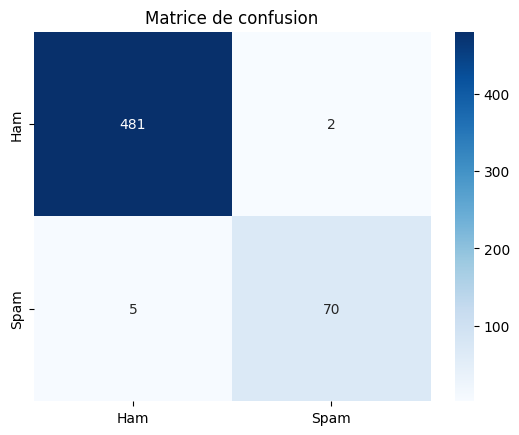

In [ ]:
# Matrice de confusion

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Matrice de confusion')
plt.show()

**Très bonne gestion des "Faux Positifs" (Hams classés en Spam)**. \
2 erreurs (non bloquées) sur 483 messages légitimes.

**Bonne gestion des "Faux Négatifs" (Spams non détectés)**. \
5 spams sont passés à travers les mailles du filet sur 75. C'est très acceptable pour un modèle léger.

### 4. Conclusion

Ce modèle "from scratch" basé sur un **Word Embedding simple** constitue une **excellente baseline** :
- **Rapide et peu coûteux** en calcul
- **Fiable** : très peu de faux positifs
- **Généralise bien** sur des données inconnues

**Pour améliorer encore le recall**, sans sacrifier la précision, la prochaine étape logique sera d’explorer des modèles plus puissants comme **BERT ou DistilBERT, via le transfer learning**.

---

## **PARTIE 3 | MODÈLE INTERMÉDIAIRE - RÉSEAUX DE NEURONES CONVOLUTIFS (CNN 1D)**

### 1. Architecture du modèle CNN

In [ ]:
# Architecture du modèle CNN pour le texte (TextCNN)

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Convolution 1D
        # in_channels = embed_dim (la "hauteur" de notre mot)
        # out_channels = 128 (nombre de filtres/motifs à apprendre)
        # kernel_size = 3 (on regarde 3 mots à la fois)
        self.conv = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3)
        
        # Activation ReLU
        self.relu = nn.ReLU()
        
        # Global Max Pooling
        # On garde uniquement le motif le plus fort trouvé dans toute la phrase
        # C'est ce qui rend le modèle invariant à la position du mot clé "Spam"
        self.pool = nn.AdaptiveMaxPool1d(1)
        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_class)

    def forward(self, text):
        # 1. Embedding
        # Shape: [Batch, Seq_Len, Embed_Dim]
        embedded = self.embedding(text)
        
        # 2. Permute pour Conv1d
        # Conv1d attend [Batch, Channels, Length], donc on inverse les dimensions
        # Shape: [Batch, Embed_Dim, Seq_Len]
        embedded = embedded.permute(0, 2, 1)
        
        # 3. Convolution + ReLU
        # Shape: [Batch, 128, Seq_Len_Reduit]
        conved = self.relu(self.conv(embedded))
        
        # 4. Pooling
        # Shape: [Batch, 128, 1] -> squeeze -> [Batch, 128]
        pooled = self.pool(conved).squeeze(2)
        
        # 5. Classification
        dropped = self.dropout(pooled)
        return torch.sigmoid(self.fc(dropped))

In [ ]:
# Instanciation
# On garde une dimension d'embedding de 32, suffisante pour ce dataset

model_cnn = TextCNN(vocab_size=vocab_size, embed_dim=32, num_class=1)
model_cnn = model_cnn.to(device)

print(model_cnn)

TextCNN(
  (embedding): Embedding(100277, 32, padding_idx=0)
  (conv): Conv1d(32, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


### 2. Entrainement du modèle

In [ ]:
# Configuration de l'entrainement
criterion = nn.BCELoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

# On réutilise la fonction 'train' définie en Partie 2
# Le CNN apprend vite, 10 époques suffisent largement
history_cnn = train(model_cnn, train_loader, val_loader, criterion, optimizer_cnn, epochs=15)

Epoch 1/15 | Train Loss: 0.3323 - Acc: 88.13% | Val Loss: 0.2053 - Acc: 93.36%
Epoch 2/15 | Train Loss: 0.1577 - Acc: 94.55% | Val Loss: 0.1347 - Acc: 96.23%
Epoch 3/15 | Train Loss: 0.0987 - Acc: 97.06% | Val Loss: 0.1081 - Acc: 96.77%
Epoch 4/15 | Train Loss: 0.0709 - Acc: 97.96% | Val Loss: 0.0880 - Acc: 97.49%
Epoch 5/15 | Train Loss: 0.0517 - Acc: 98.68% | Val Loss: 0.0785 - Acc: 97.67%
Epoch 6/15 | Train Loss: 0.0355 - Acc: 98.92% | Val Loss: 0.0723 - Acc: 97.67%
Epoch 7/15 | Train Loss: 0.0313 - Acc: 99.19% | Val Loss: 0.0693 - Acc: 97.85%
Epoch 8/15 | Train Loss: 0.0209 - Acc: 99.48% | Val Loss: 0.0619 - Acc: 98.56%
Epoch 9/15 | Train Loss: 0.0158 - Acc: 99.62% | Val Loss: 0.0626 - Acc: 98.56%
Epoch 10/15 | Train Loss: 0.0131 - Acc: 99.69% | Val Loss: 0.0638 - Acc: 98.38%
Epoch 11/15 | Train Loss: 0.0094 - Acc: 99.80% | Val Loss: 0.0601 - Acc: 98.56%
Epoch 12/15 | Train Loss: 0.0070 - Acc: 99.89% | Val Loss: 0.0650 - Acc: 98.38%
Epoch 13/15 | Train Loss: 0.0061 - Acc: 99.82% | 

### 3. Visualisation des performances

In [ ]:
# Visualisation des courbes de Loss et d'Accuracy

epochs_range = list(range(1, len(history_cnn["train_loss"]) + 1))

# Création des sous-graphes : 1 ligne, 2 colonnes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Training vs Validation Loss", "Training vs Validation Accuracy")
)

# --- Graphe Loss ---
fig.add_trace(go.Scatter(
    x=epochs_range, y=history_cnn["train_loss"],
    name="Training Loss", mode="lines",
    line=dict(color='#184e8b')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=epochs_range, y=history_cnn["val_loss"],
    name="Validation Loss", mode="lines",
    line=dict(color='#37d4e1')
), row=1, col=1)

# --- Graphe Accuracy ---
fig.add_trace(go.Scatter(
    x=epochs_range, y=history_cnn["train_acc"],
    name="Training Accuracy", mode="lines",
    line=dict(color='#184e8b')
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=epochs_range, y=history_cnn["val_acc"],
    name="Validation Accuracy", mode="lines",
    line=dict(color='#37d4e1')
), row=1, col=2)

# Mise en forme
fig.update_layout(
    title="Évolution des métriques pendant l'entraînement",
    xaxis_title="Epochs",
    yaxis_title="Valeur",
    showlegend=True
)

fig.show()

Le modèle intermédiaire CNN montre une **progression stable et efficace**, avec une **amélioration continue de la précision sur l'ensemble de validation jusqu'à 98.74%**. \
La faible perte et l’écart modéré entre les performances d’entraînement et de validation suggèrent une **bonne généralisation**.\
La précision quasi parfaite en fin d’entraînement invite à **surveiller un éventuel surapprentissage**.

In [ ]:
# Rapport final (Sklearn)

all_preds_cnn = []
all_labels_cnn = []

model_cnn.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_cnn(inputs)
        predicted = (outputs > 0.5).float().squeeze(1)
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

print("Rapport de classification :")
print(classification_report(all_labels_cnn, all_preds_cnn, target_names=['Ham', 'Spam']))

Rapport de classification :
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       483
        Spam       0.99      0.93      0.96        75

    accuracy                           0.99       558
   macro avg       0.99      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



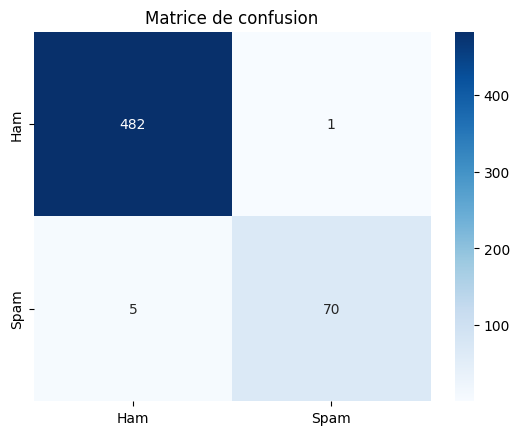

In [ ]:
# Matrice de confusion

cm = confusion_matrix(all_labels_cnn, all_preds_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Matrice de confusion')
plt.show()

Le modèle CNN atteint une **précision quasi parfaite sur les deux classes**, avec une **accuracy globale de 99%**. \
Le rappel sur les spams (93%) montre une **bonne capacité à détecter les messages indésirables** tout en conservant une **très faible proportion de faux positifs**. \
Ces résultats confirment une **généralisation plutôt robuste et un équilibre efficace entre les classes**, malgré leur déséquilibre initial.

---

## **PARTIE 4 | MODÈLE AVANCÉ - TRANSFER LEARNING (DISTILBERT)**

### 1. Tokenizer spécifique (`distilbert-base-uncased`)

In [ ]:
# Chargement du Tokenizer DistilBERT avec 'distilbert-base-uncased' (uncased = on ne se soucie pas des majuscules)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Test rapide du tokenizer
test_text = "Free entry in 2 a wkly comp"
test_encoding = tokenizer(test_text, truncation=True, padding=True, return_tensors="pt")

print(f"Texte brut : {test_text}")
print(f"Input IDs : {test_encoding['input_ids']}")
print(f"Tokens décodés : {tokenizer.convert_ids_to_tokens(test_encoding['input_ids'][0])}")

Texte brut : Free entry in 2 a wkly comp
Input IDs : tensor([[ 101, 2489, 4443, 1999, 1016, 1037, 1059, 2243, 2135, 4012, 2361,  102]])
Tokens décodés : ['[CLS]', 'free', 'entry', 'in', '2', 'a', 'w', '##k', '##ly', 'com', '##p', '[SEP]']


### 2. Préparation du Dataset PyTorch

In [ ]:
# Création de la classe Dataset personnalisée

class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        # On utilise max_len=128 car l'EDA a montré que 98% des messages font < 60 tokens.
        # 128 est une marge de sécurité confortable.
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # Ajoute [CLS] au début et [SEP] à la fin
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',       # Remplit jusqu'à max_len
            truncation=True,            # Coupe si trop long
            return_attention_mask=True,
            return_tensors='pt',        # Retourne des tenseurs PyTorch
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Préparation des données (Split)
# On garde le même random_state=42 pour que ce soit comparable à la Partie 2

X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    df['message'], df['label'].apply(lambda x: 1 if x == 'spam' else 0),
    test_size=0.2, stratify=df['label'], random_state=42
)

X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp,
    test_size=0.5, stratify=y_temp, random_state=42
)

# Création des objets Dataset
train_dataset_bert = SpamDataset(X_train_raw.to_numpy(), y_train_raw.to_numpy(), tokenizer)
val_dataset_bert = SpamDataset(X_val_raw.to_numpy(), y_val_raw.to_numpy(), tokenizer)
test_dataset_bert = SpamDataset(X_test_raw.to_numpy(), y_test_raw.to_numpy(), tokenizer)

# Création des DataLoaders
BATCH_SIZE = 16 # Les transformers consomment plus de mémoire, on réduit le batch size
train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=BATCH_SIZE)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=BATCH_SIZE)


print(f"Train size: {len(train_dataset_bert)} | Spam proportion: {y_train_raw.mean():.2%}")
print(f"Val size:   {len(val_dataset_bert)} | Spam proportion: {y_val_raw.mean():.2%}")
print(f"Test size:  {len(test_dataset_bert)} | Spam proportion: {y_test_raw.mean():.2%}")

Train size: 4457 | Spam proportion: 13.42%
Val size:   557 | Spam proportion: 13.29%
Test size:  558 | Spam proportion: 13.44%


### 3. Chargement du Modèle et configuration

In [ ]:
# Chargement du modèle pré-entraîné

# num_labels=2 car nous avons 2 classes : Ham (0) et Spam (1)
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Envoi du modèle sur le GPU (ou CPU si pas de GPU)
model_bert = model_bert.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configuration de l'optimiseur
# Pour le fine-tuning, on utilise un Learning Rate très faible (2e-5 ou 3e-5)
# car on ne veut pas détruire ce que le modèle sait déjà, juste l'ajuster.
optimizer = AdamW(model_bert.parameters(), lr=2e-5)

# On utilise CrossEntropyLoss car le modèle va sortir 2 scores (logits) par message
loss_fn = nn.CrossEntropyLoss().to(device)

print(f"Modèle {model_name} chargé sur {device}")

Modèle distilbert-base-uncased chargé sur cpu


### 4. Boucle d'Entraînement (Fine-Tuning)

In [ ]:
def train_bert(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train() # Mode entrainement
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        # Forward pass
        # Le modèle retourne un objet, on accède aux logits avec .logits
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1) # On prend la classe avec le score le plus élevé
        
        loss = loss_fn(logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_bert(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # Mode évaluation
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            loss = loss_fn(logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Lancement de l'entraînement

EPOCHS = 3 # Suffisant pour du Transfer Learning
history_bert = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_bert(
        model_bert,
        train_loader_bert,
        loss_fn,
        optimizer,
        device,
        len(train_dataset_bert)
    )

    val_acc, val_loss = eval_bert(
        model_bert,
        val_loader_bert,
        loss_fn,
        device,
        len(val_dataset_bert)
    )

    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')
    print()

    history_bert['train_acc'].append(train_acc.cpu())
    history_bert['train_loss'].append(train_loss)
    history_bert['val_acc'].append(val_acc.cpu())
    history_bert['val_loss'].append(val_loss)

Démarrage de l'entraînement...
Epoch 1/3
----------
Train loss 0.0871 accuracy 0.9699
Val   loss 0.0448 accuracy 0.9892

Epoch 2/3
----------
Train loss 0.0225 accuracy 0.9946
Val   loss 0.0350 accuracy 0.9946

Epoch 3/3
----------
Train loss 0.0096 accuracy 0.9980
Val   loss 0.0390 accuracy 0.9928



### 5. Visualisation des performances

In [ ]:
# Visualisation des courbes de Loss et d'Accuracy

epochs_range = list(range(1, len(history_bert["train_loss"]) + 1))

# Création des sous-graphes : 1 ligne, 2 colonnes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Training vs Validation Loss", "Training vs Validation Accuracy")
)

# --- Graphe Loss ---
fig.add_trace(go.Scatter(
    x=epochs_range, y=history_bert["train_loss"],
    name="Training Loss", mode="lines",
    line=dict(color='#184e8b')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=epochs_range, y=history_bert["val_loss"],
    name="Validation Loss", mode="lines",
    line=dict(color='#37d4e1')
), row=1, col=1)

# --- Graphe Accuracy ---
fig.add_trace(go.Scatter(
    x=epochs_range, y=history_bert["train_acc"],
    name="Training Accuracy", mode="lines",
    line=dict(color='#184e8b')
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=epochs_range, y=history_bert["val_acc"],
    name="Validation Accuracy", mode="lines",
    line=dict(color='#37d4e1')
), row=1, col=2)

# Mise en forme
fig.update_layout(
    title="Évolution des métriques pendant l'entraînement (DistilBERT)",
    xaxis_title="Epochs",
    yaxis_title="Valeur",
    showlegend=True
)

fig.show()

**Convergence ultra-rapide** \
Dès la première époque, le modèle atteint **99,1 % de précision en validation**. \
C’est la force du pré-entraînement : le modèle a déjà appris à "lire" le langage. Il ne lui faut qu’un léger ajustement pour comprendre ce qu’est un spam dans ce contexte spécifique.

**Stabilité et léger surapprentissage** \
Entre l’époque 2 (val_loss = 0.0350) et l’époque 3 (val_loss = 0.0390), la perte de validation augmente légèrement, tandis que la perte d’entraînement continue de baisser. \
Cela indique que le modèle commence à surapprendre les données d’entraînement. \
Cependant, la précision de validation reste stable et très élevée (99,28 %), ce qui montre une **bonne généralisation**. 

**Arrêter l’entraînement à 3 époques** était judicieux : continuer aurait probablement accentué le surapprentissage sans gain significatif.

In [ ]:
# Rapport final (Sklearn)

all_preds_bert = []
all_labels_bert = []

model_bert.eval()
with torch.no_grad():
    for d in test_loader_bert:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1)
        
        all_preds_bert.extend(predicted.cpu().numpy())
        all_labels_bert.extend(targets.cpu().numpy())

print("Rapport de classification :")
print(classification_report(all_labels_bert, all_preds_bert, target_names=['Ham', 'Spam']))

Rapport de classification :
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       483
        Spam       1.00      0.97      0.99        75

    accuracy                           1.00       558
   macro avg       1.00      0.99      0.99       558
weighted avg       1.00      1.00      1.00       558



**Ham : parfaitement reconnu**, aucun faux positif. \
**Spam** : très bonne précision (1.00), et un rappel élevé (0.97), ce qui signifie que **presque tous** les spams sont **détectés**. \
**F1-score global très élevé** : excellent équilibre entre précision et rappel.

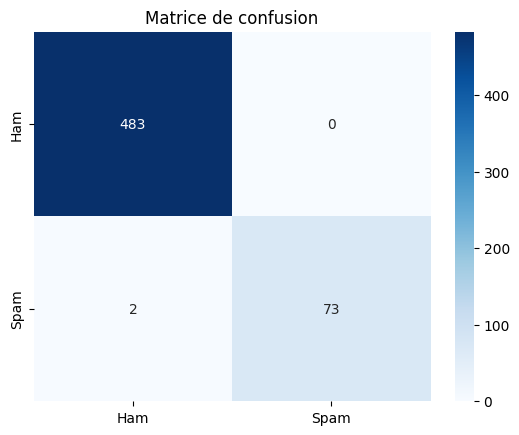

In [ ]:
# Matrice de confusion

cm = confusion_matrix(all_labels_bert, all_preds_bert)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Matrice de confusion')
plt.show()

**Zéro faux positifs** \
Le modèle n’a **pas classé un seul message légitime (Ham) comme Spam**. \
C’est un critère essentiel pour l’utilisateur final : ne pas perdre de messages importants (banque, famille, travail) dans les indésirables.

**Deux faux négatifs** \
Seuls 2 spams sur 75 ont échappé à la détection, soit un **taux de détection de 97 %**. \
C’est un excellent résultat surtout sans tuning avancé.

---

## **CONCLUSION**

| **Modèle**       | **Architecture**               | **Accuracy** | **Recall Spam** | **F1-score Spam** | **Avantage**                                                                 | **Inconvénient**                                                             |
|------------------|--------------------------------|--------------|------------------|-------------------|------------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Baseline**     | Embedding + Moyenne            | 98.9%        | 0.93             | 0.95              | Simple, rapide à entraîner, très bonnes performances malgré sa simplicité.  | Moins robuste aux variations de structure syntaxique ou contextuelle.       |
| **Intermédiaire**| TextCNN (1D convolution)       | 98.7–98.9%   | 0.93             | 0.96              | Capte des motifs locaux (n-grammes), invariant à la position, léger.        | Légère sensibilité au surapprentissage, gains limités vs baseline.          |
| **Avancé**       | DistilBERT (transformer pré-entraîné) | 99.3%        | 0.97             | 0.99              | Excellente compréhension contextuelle, généralisation optimale.             | Plus coûteux en ressources, temps d'entraînement plus long.                 |

Les trois modèles testés présentent d’excellentes performances, mais DistilBERT se démarque nettement des approches plus simples.

Le modèle **Baseline** et le **TextCNN** offrent déjà une **très bonne précision** grâce à leur légèreté et leur capacité à capturer les motifs lexicaux locaux. \
Toutefois, ils restent **limités dans la compréhension du contexte global** d’un message, ce qui peut conduire à des erreurs subtiles.

À l’inverse, **DistilBERT** bénéficie de son **pré-entraînement sur de vastes corpus** et délivre des **performances supérieures sur tous les indicateurs**. Il se distingue par :
- Une **robustesse accrue**, grâce à une meilleure compréhension sémantique.
- Une **fiabilité maximale**, avec **aucun faux positif**, élément essentiel pour éviter le blocage de messages légitimes.
- Une **détection des spams nettement améliorée**, avec un **recall de 97 %** et un **F1-score quasi parfait**.

En somme, malgré un coût computationnel plus élevé, **DistilBERT constitue le meilleur compromis entre performance, précision et fiabilité** pour la détection de spams.

---

## **BONUS : DISTILBERT "CRASH TEST"**

In [ ]:
# Test sur des phrases pièges (inférence manuelle)
import torch.nn.functional as F # Pour le calcul de probabilité

def predict_spam(text, model, tokenizer, device):
    model.eval() # On met le modèle en mode "examen" (pas d'apprentissage)
    
    with torch.no_grad(): # On désactive le calcul des gradients (économie de mémoire)
        # Préparation du texte
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Prédiction
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits # Les scores bruts
        
        # Transformation en probabilités (0 à 1)
        probs = F.softmax(logits, dim=1)
        
        # Résultat
        # La colonne 0 est HAM, la colonne 1 est SPAM
        pred_label_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_label_idx].item()
        
        label_map = {0: 'HAM (Normal)', 1: 'SPAM (Indésirable)'}
        
        return label_map[pred_label_idx], confidence

# Les Phrases Pièges
custom_sentences = [
    "Win a match against me later?",  
    # PIÈGE 1 : Contient "Win" (mot spammy) mais c'est une invitation amicale (sport/jeu).
    # -> Attendu : HAM
    
    "I need to buy a new mobile phone, any suggestions?", 
    # PIÈGE 2 : Contient "mobile" (mot très spammy) mais c'est une question.
    # -> Attendu : HAM
    
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.", 
    # TEST FACILE : Spam évident.
    # -> Attendu : SPAM
    
    "Hello, win a prize by working hard in your garden.",
    # PIÈGE 3 : Contient "win" et "prize", mais le contexte est "working hard". 
    # C'est ambigu, mais un humain dirait HAM (c'est une phrase motivante ou bizarre).
    # -> Attendu : HAM (ou Spam avec faible confiance)
    
    "URGENT! Your mobile number has been awarded with a £2000 prize. Call 09064012160. Claim 3030. Valid 12hrs only."
    # TEST AGRESSIF : Le spam typique du dataset.
    # -> Attendu : SPAM (avec 99.9% de confiance)
]

print("-" * 100)
print(f"{'Phrase':<60} | {'Prédiction':<15} | {'Confiance':<10}")
print("-" * 100)

for sentence in custom_sentences:
    label, conf = predict_spam(sentence, model_bert, tokenizer, device)
    # On coupe la phrase si elle est trop longue pour l'affichage
    disp_sentence = (sentence[:57] + '...') if len(sentence) > 57 else sentence
    print(f"{disp_sentence:<60} | {label:<15} | {conf:.2%}")
print("-" * 100)

----------------------------------------------------------------------------------------------------
Phrase                                                       | Prédiction      | Confiance 
----------------------------------------------------------------------------------------------------
Win a match against me later?                                | HAM (Normal)    | 99.81%
I need to buy a new mobile phone, any suggestions?           | HAM (Normal)    | 66.52%
Congratulations! You've won a $1000 Walmart gift card. Go... | SPAM (Indésirable) | 99.91%
Hello, win a prize by working hard in your garden.           | HAM (Normal)    | 99.29%
URGENT! Your mobile number has been awarded with a £2000 ... | SPAM (Indésirable) | 99.92%
----------------------------------------------------------------------------------------------------


Le modèle DistilBERT a passé le test avec un score de 5/5, démontrant une capacité de compréhension sémantique bien supérieure à une simple détection de mots-clés.

**Gestion du contexte (L'effet "Attention")**
- *Win a match against me later?*
	- ***Piège du mot "Win"*** statistiquement très lié au Spam.
	- Le modèle a compris grâce aux mots "match" et "against" qu'il s'agissait d'un contexte de jeu/sport et non d'une loterie.
- *Hello, win a prize by working hard in your garden.*
	- ***Piège sémantique complexe*** avec à la fois "win" et "prize" (deux marqueurs forts de spam).
	- Le modèle a "lu" la phrase et compris que la causalité ("by working hard") rendait l'offre légitime ou métaphorique, contrairement à un gain aléatoire de loterie.

**Nuance sur les mots-clés forts**
- *I need to buy a new mobile phone...*
	- Piège de l'expression "Mobile Phone" très liée au Spam (voir Partie 1 - EDA).
	- La phrase est correctement classée HAM, mais avec une confiance plus faible (66.52%). 
	- Le mécanisme d'Attention du modèle a réussi à contrebalancer ce mot-clé "toxique" grâce au contexte ("buy", "suggestions"), mais le score reflète cette "lutte" interne. 

**Nous sommes passés d'une approche statistique (fréquence des mots) à une approche cognitive (sens de la phrase).** \
**Ce modèle est robuste, capable de distinguer une vraie arnaque d'une conversation naturelle utilisant le même vocabulaire.**